# core

> Fill in a module description here

In [ ]:
# | default_exp core

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | hide
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
loan_data = pd.read_csv("../data/loan_data_2007_2014.csv", low_memory=False)

In [ ]:
loan_data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.00,0.00,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.00,0.00,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.90,766.90,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,C2,Financial Advisor,4 years,MORTGAGE,110000.0,Source Verified,Jan-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,773xx,TX,19.85,0.0,Apr-03,2.0,NaN,N

In [ ]:
# drop columns with more than 80% null values
loan_data = loan_data.dropna(thresh=loan_data.shape[0] * 0.2, how="all", axis=1)

In [ ]:
loan_data.shape

(466285, 56)

In [ ]:
# drop all redundant and forward-looking columns
loan_data = loan_data.drop(
    columns=[
        "id",
        "member_id",
        "sub_grade",
        "emp_title",
        "url",
        "desc",
        "title",
        "zip_code",
        "next_pymnt_d",
        "recoveries",
        "collection_recovery_fee",
        "total_rec_prncp",
        "total_rec_late_fee",
    ]
)

In [ ]:
loan_data.shape

(466285, 43)

In [ ]:
# explore the unique values in loan_status column
loan_data["loan_status"].value_counts(normalize=True)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [ ]:
# create a new column based on the loan_status column that will be our target variable
default_columns = [
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Does not meet the credit policy. Status:Charged Off",
]
loan_data["good_bad"] = np.where(
    loan_data.loc[:, "loan_status"].isin(default_columns), 0, 1
)

In [ ]:
loan_data

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,credit_card,AZ,27.65,0.0,Jan-85,1.0,NaN,3.0,0.0,13648,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,861.07,Jan-15,171.62,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,car,GA,1.00,0.0,Apr-99,5.0,NaN,3.0,0.0,1687,9.4,4.0,f,0.00,0.00,1008.710000,1008.71,435.17,Apr-13,119.66,Sep-13,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,small_business,IL,8.72,0.0,Nov-01,2.0,NaN,2.0,0.0,2956,98.5,10.0,f,0.00,0.00,3003.653644,3003.65,603.65,Jun-14,649.91,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,other,CA,20.00,0.0,Feb-96,1.0,35.0,10.0,0.0,5598,21.0,37.0,f,0.00,0.00,12226.302210,12226.30,2209.33,Jan-15,357.48,Jan-15,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
4,3000,3000,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,other,OR,17.94,0.0,Jan-96,0.0,38.0,15.0,0.0,27783,53.9,38.0,f,766.90,766.90,3242.170000,3242.17,1009.07,Jan-16,67.79,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,18400,18400.0,60 months,14.47,432.64,C,4 years,MORTGAGE,110000.0,Source Verified,Jan-14,Current,n,debt_consolidation,TX,19.85,0.0,Apr-03,2.0,NaN,18.0,0.0,23208,77.6,36.0,w,12574.00,12574.00,10383.360000,10383.36,4557.36,Jan-16,432.64,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,0.0,294998.0,29900.0,1
466281,22000,22000,22000.0,60 months,19.97,582.50,D,10+ years,MORTGAGE,78000.0,Verified,Jan-14,Charged Off,n,debt_consolidation,TN,18.45,0.0,Jun-97,5.0,NaN,18.0,1.0,18238,46.3,30.0,f,0.00,0.00,4677.920000,4677.92,2840.88,Dec-14,17.50,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,0.0,221830.0,39400.0,0
466282,20700,20700,20700.0,60 months,16.99,514.34,D,7 years,MORTGAGE,46000.0,Verified,Jan-14,Current,n,debt_consolidation,OH,25.65,0.0,Dec-01,2.0,65.0,18.0,0.0,6688,51.1,43.0,f,14428.31,14428.31,12343.980000,12343.98,6072.29,Jan-16,514.34,Dec-15,0.0,NaN,1,INDIVIDUAL,0.0,0.0,73598.0,13100.0,1
466283,2000,2000,2000.0,36 months,7.90,62.59,A,3 years,OWN,83000.0,Verified,Jan-14,Fully Paid,n,credit_card,CA,5.39,3.0,Feb-03,1.0,13.0,21.0,0.0,11404,21.5,27.0,w,0.00,0.00,2126.579838,2126.58,126.58,Dec-14,1500.68,Apr-15,0.0,NaN,1,INDIVIDUAL,0.0,0.0,591610.0,53100.0,1


In [ ]:
# Drop the original 'loan_status' column
loan_data = loan_data.drop(columns=["loan_status"])

In [ ]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = loan_data.drop("good_bad", axis=1)
y = loan_data["good_bad"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Hard copy the X datasets to avoid Pandas' `SetttingWithCopyWarning` when we play around with this data later on. This is currently an open issue between Pandas and Scikit-Learn teams

In [ ]:
X_train, X_test = X_train.copy(), X_test.copy()

Function to clean up the emp_length column, assign 0 to NANs, and convert to numeric

In [ ]:
def emp_length_converter(df, column):
    df[column] = df[column].str.replace("\+ years", "")
    df[column] = df[column].str.replace("< 1 year", str(0))
    df[column] = df[column].str.replace(" years", "")
    df[column] = df[column].str.replace(" year", "")
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value=0, inplace=True)
    return df

Function to convert date columns to datetime format and create a new column as a difference between today and the respective date

In [ ]:
def date_columns(df, column):
    today_date = pd.to_datetime("2020-08-01")  # store current month
    df[column] = pd.to_datetime(
        df[column], format="%b-%y"
    )  # convert to datetime format
    # calculate the difference in months and add to a new column
    df[f"mths_since_{column}"] = round(
        pd.to_numeric((today_date - df[column]) / np.timedelta64(1, "M"))
    )
    # make any resulting -ve values to be equal to the max date
    df[f"mths_since_{column}"] = df[f"mths_since_{column}"].apply(
        lambda x: df[f"mths_since_{column}"].max() if x < 0 else x
    )
    df = df.drop(columns=[column])  # drop the original date column
    return df

In [ ]:
# function to remove 'months' string from the 'term' column and convert it to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(" months", ""))
    return df

In [ ]:
# apply these functions to X_train
X_train = date_columns(X_train, "earliest_cr_line")
X_train = date_columns(X_train, "issue_d")
X_train = date_columns(X_train, "last_pymnt_d")
X_train = date_columns(X_train, "last_credit_pull_d")
X_train = emp_length_converter(X_train, "emp_length")
X_train = loan_term_converter(X_train, "term")

/var/folders/qz/3pl78vgn6t7cltx35ttht03r0000gn/T/ipykernel_46843/3838003293.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\+ years', '')


In [ ]:
X_train

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
456615,15000,15000,15000.0,36,8.90,476.30,A,7.0,MORTGAGE,80000.0,Source Verified,n,credit_card,WI,17.01,1.0,0.0,20.0,19.0,0.0,20699,59.0,32.0,w,0.00,0.00,16561.02000,16561.02,1561.02,8940.22,0.0,NaN,1,INDIVIDUAL,0.0,0.0,143586.0,35100.0,296.0,79.0,62.0,55.0
451541,8000,8000,8000.0,60,18.25,204.24,D,10.0,OWN,44000.0,Verified,n,other,TN,23.46,0.0,1.0,NaN,12.0,0.0,13245,32.1,25.0,f,5746.54,5746.54,4697.52000,4697.52,2444.06,204.24,0.0,NaN,1,INDIVIDUAL,0.0,0.0,180443.0,41300.0,301.0,79.0,55.0,55.0
394474,12150,12150,12100.0,60,18.92,314.65,D,3.0,OWN,27000.0,Source Verified,n,credit_card,TN,31.07,1.0,0.0,10.0,9.0,0.0,7172,73.2,22.0,f,9282.24,9244.04,6293.00000,6267.10,3425.24,314.65,0.0,NaN,1,INDIVIDUAL,0.0,0.0,34197.0,9800.0,359.0,75.0,55.0,55.0
110294,10000,10000,10000.0,36,6.03,304.36,A,3.0,MORTGAGE,33000.0,Not Verified,n,debt_consolidation,TN,9.16,0.0,0.0,NaN,5.0,0.0,2138,21.2,17.0,w,0.00,0.00,10858.01000,10858.01,858.01,3553.37,0.0,NaN,1,INDIVIDUAL,0.0,0.0,77959.0,10100.0,224.0,84.0,59.0,59.0
139343,15825,15825,15825.0,36,12.12,526.53,B,10.0,MORTGAGE,59000.0,Verified,n,debt_consolidation,WA,17.94,0.0,0.0,NaN,7.0,0.0,30326,93.6,31.0,f,0.00,0.00,4736.52000,4736.52,1301.35,526.53,0.0,NaN,1,INDIVIDUAL,0.0,0.0,187370.0,32400.0,494.0,87.0,78.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163633,22800,22800,22800.0,60,16.29,557.98,C,10.0,MORTGAGE,85000.0,Verified,n,debt_consolidation,CA,15.12,0.0,0.0,38.0,15.0,0.0,18556,67.5,22.0,f,12158.37,12158.37,18968.20000,18968.20,8326.57,557.98,0.0,NaN,1,INDIVIDUAL,0.0,0.0,29071.0,27500.0,253.0,90.0,55.0,55.0
399306,20275,20275,20175.0,36,12.49,678.18,B,7.0,MORTGAGE,48000.0,Verified,n,credit_card,KS,22.70,0.0,0.0,NaN,7.0,0.0,33997,75.0,20.0,w,9947.82,9898.75,13563.60000,13496.70,3236.42,678.18,0.0,NaN,1,INDIVIDUAL,0.0,0.0,186530.0,45300.0,230.0,75.0,55.0,55.0
57787,25000,25000,24975.0,60,14.30,585.61,C,0.0,MORTGAGE,65530.0,Verified,n,debt_consolidation,CO,22.91,0.0,0.0,NaN,8.0,0.0,11848,68.1,24.0,f,0.00,0.00,30285.29598,30255.01,5285.30,19162.85,0.0,NaN,1,INDIVIDUAL,0.0,0.0,290599.0,17400.0,314.0,81.0,60.0,56.0
81641,10000,10000,10000.0,36,15.10,347.15,C,4.0,MORTGAGE,50000.0,Not Verified,n,debt_consolidation,FL,14.24,1.0,1.0,10.0,7.0,0.0,9693,65.1,9.0,w,2936.24,2936.24,9373.05000,9373.05,2309.29,347.15,0.0,40.0,1,INDIVIDUAL,0.0,0.0,27715.0,14900.0,156.0,82.0,55.0,55.0


In [ ]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include="object").copy()
X_train_num = X_train.select_dtypes(include="number").copy()

In [ ]:
chi2_check = {}  # define an empty dictionary to store chi-squared test results
# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault("Feature", []).append(column)
    chi2_check.setdefault("p-value", []).append(round(p, 10))
chi2_result = pd.DataFrame(data=chi2_check)  # convert the dictionary to a DF
chi2_result.sort_values(by=["p-value"], ascending=True, ignore_index=True, inplace=True)

In [ ]:
chi2_result

,Feature,p-value
0,grade,0.000000
1,home_ownership,0.000000
2,verification_status,0.000000
3,purpose,0.000000
4,addr_state,0.000000
5,initial_list_status,0.000000
6,pymnt_plan,0.000923
7,application_type,1.000000


/Users/henrydashwood/.pyenv/versions/3.10.3/envs/py3103/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/henrydashwood/.pyenv/versions/3.10.3/envs/py3103/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


<AxesSubplot:>

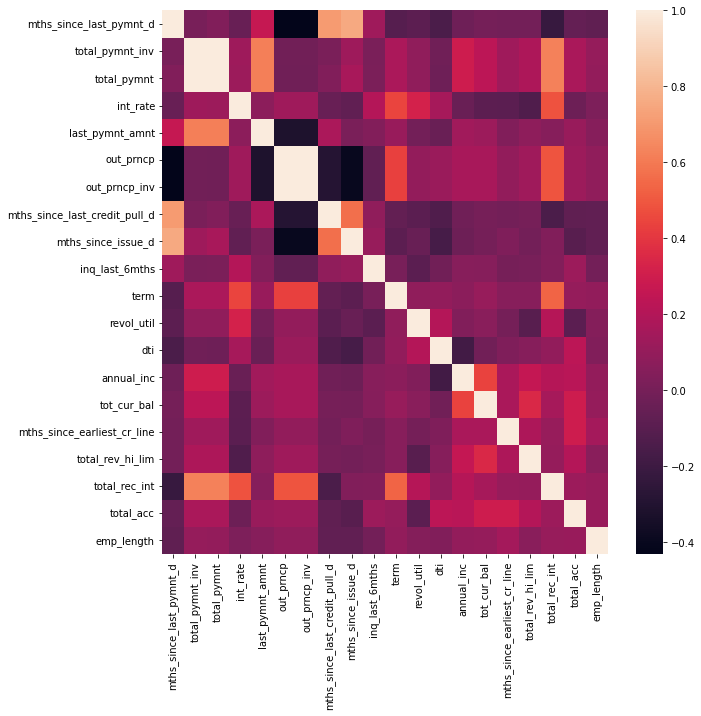

In [ ]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace=True)

# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)

# convert to a DF
ANOVA_F_table = pd.DataFrame(
    data={
        "Numerical_Feature": X_train_num.columns.values,
        "F-Score": F_statistic,
        "p values": p_values.round(decimals=10),
    }
)
ANOVA_F_table = ANOVA_F_table.sort_values(by=["F-Score"], ascending=False, ignore_index=True)

# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:20, 0].to_list()

# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corrmat)

In [ ]:
# save the names of columns to be dropped in a list
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(["out_prncp_inv", "total_pymnt_inv"])

# function to drop these columns
def col_to_drop(df, columns_list):
    df = df.drop(columns=columns_list)
    return df

# apply to X_train
X_train = col_to_drop(X_train, drop_columns_list)

In [ ]:
X_train

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,total_acc,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
456615,36,8.90,A,7.0,MORTGAGE,80000.0,Source Verified,credit_card,17.01,0.0,59.0,32.0,0.00,16561.02000,1561.02,8940.22,143586.0,35100.0,296.0,79.0,62.0,55.0
451541,60,18.25,D,10.0,OWN,44000.0,Verified,other,23.46,1.0,32.1,25.0,5746.54,4697.52000,2444.06,204.24,180443.0,41300.0,301.0,79.0,55.0,55.0
394474,60,18.92,D,3.0,OWN,27000.0,Source Verified,credit_card,31.07,0.0,73.2,22.0,9282.24,6293.00000,3425.24,314.65,34197.0,9800.0,359.0,75.0,55.0,55.0
110294,36,6.03,A,3.0,MORTGAGE,33000.0,Not Verified,debt_consolidation,9.16,0.0,21.2,17.0,0.00,10858.01000,858.01,3553.37,77959.0,10100.0,224.0,84.0,59.0,59.0
139343,36,12.12,B,10.0,MORTGAGE,59000.0,Verified,debt_consolidation,17.94,0.0,93.6,31.0,0.00,4736.52000,1301.35,526.53,187370.0,32400.0,494.0,87.0,78.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163633,60,16.29,C,10.0,MORTGAGE,85000.0,Verified,debt_consolidation,15.12,0.0,67.5,22.0,12158.37,18968.20000,8326.57,557.98,29071.0,27500.0,253.0,90.0,55.0,55.0
399306,36,12.49,B,7.0,MORTGAGE,48000.0,Verified,credit_card,22.70,0.0,75.0,20.0,9947.82,13563.60000,3236.42,678.18,186530.0,45300.0,230.0,75.0,55.0,55.0
57787,60,14.30,C,0.0,MORTGAGE,65530.0,Verified,debt_consolidation,22.91,0.0,68.1,24.0,0.00,30285.29598,5285.30,19162.85,290599.0,17400.0,314.0,81.0,60.0,56.0
81641,36,15.10,C,4.0,MORTGAGE,50000.0,Not Verified,debt_consolidation,14.24,1.0,65.1,9.0,2936.24,9373.05000,2309.29,347.15,27715.0,14900.0,156.0,82.0,55.0,55.0


In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()